# 5.1 Bond behavior governed by damage
 
Basic framework of
elasto-plastic models showing which conditions are used to find out how  
to describe the material behavior, once it crosses the elastic limit.

**Outline**
 * Meaning of damage and examples of damage functions

 * How to incorporate it into the framework for inelastic simulation 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Elastic,-ideally-plastic-behavior" data-toc-modified-id="Elastic,-ideally-plastic-behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Elastic, ideally plastic behavior</a></span><ul class="toc-item"><li><span><a href="#Yield-condition" data-toc-modified-id="Yield-condition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Yield condition</a></span></li><li><span><a href="#Elastic-behavior" data-toc-modified-id="Elastic-behavior-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Elastic behavior</a></span></li><li><span><a href="#Evolution-equation" data-toc-modified-id="Evolution-equation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Evolution equation</a></span></li><li><span><a href="#Consistency-condition" data-toc-modified-id="Consistency-condition-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Consistency condition</a></span></li></ul></li><li><span><a href="#Numerical-iterative-solution" data-toc-modified-id="Numerical-iterative-solution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical iterative solution</a></span><ul class="toc-item"><li><span><a href="#Discrete-yield-condition" data-toc-modified-id="Discrete-yield-condition-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discrete yield condition</a></span></li><li><span><a href="#State-update" data-toc-modified-id="State-update-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>State update</a></span></li><li><span><a href="#Predictor-operator" data-toc-modified-id="Predictor-operator-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Predictor operator</a></span></li><li><span><a href="#Time-stepping-algorithm" data-toc-modified-id="Time-stepping-algorithm-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Time stepping algorithm</a></span></li><li><span><a href="#Tasks-and-questions" data-toc-modified-id="Tasks-and-questions-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Tasks and questions</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
sp.init_printing()

## Elastic, ideally plastic behavior
Assuming a constant yielding stress $\tau_\mathrm{Y}$ and no hardening the possible paths along which the stress strain states can develop are depicted in Figure 1.
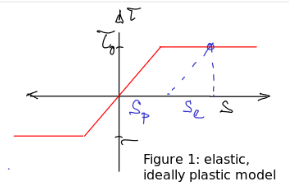

### Yield condition
Elastic domain is defined by the inequality equation
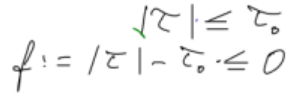
\begin{align}
f := | \tau| - \tau_Y \le 0
\label{eq:f_perfect_plasticity}
\end{align}

In [31]:
s, z, dot_z = sp.symbols(r's, z, \dot{z}')
E_b = sp.symbols('E_b', positive=True)
K = sp.symbols('K', positive=True)
Z = sp.symbols('Z')
Z_ = K * z
dot_Z_ = K * dot_z
omega = sp.symbols('omega', nonnegative=True)
tau_ =  (1 - omega) * E_b * (s)
tau_

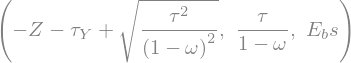

In [33]:
tau, tau_eff = sp.symbols(r'\tau, \tau_\mathrm{eff}')
tau_eff_ = tau/(1-omega) 
tau_Y = sp.symbols(r'tau_Y', real=True, nonnegative=True)
f_tau_eff_ = sp.sqrt( tau_eff*tau_eff ) - tau_Y - Z
f_tau_ = f_tau_eff_.subs(tau_eff, tau_eff_)
f_tau_, tau_eff_, tau_eff_.subs(tau, tau_)

&nbsp;<font color='blue'>
**Naming conventions:**
 - Variables with trailing underscore (e.g. `f_tau_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `tau` have no underscore at the end and have an the name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `sp.symbols(r'\tau')` use `latex` syntax to introduce greek symbols, super and subindexes. This makes the pretty printing of expression possible.
 - In an implemented algorithm at the end of the notebook, the Python variables containing the numerical values of the material parameters $E_b$, $\tau_\mathrm{Y}$, etc. are denoted with a leading underscore `_E_b` and `_tau_Y` to avoid name collisions within the notebook
</font>

### Elastic behavior
\begin{align}
\tau = E_\mathrm{b} s(s - s_\mathrm{pl})
\label{eq:elastic_behavior}
\end{align}

### Evolution equation
Let us be more precise in defining the goal of the derivation: Inelastic behavior is path dependent. That means: <font color="brown"> **during yielding, the value of stress does not depend only on the value of slip but also on the history of loading in a material point.**</font> Thus, we cannot get an explicit relation between the stress and slip. 

We need further criteria that would help us
 * <font color="green">to find out **in which direction does the yielding process proceed** from a current state, and</font>
 * <font color="green">to account for **the loading history that a material point** experienced in the past.</font>

In other words, we want to establish the relation between stress and strain (or shear and slip) in a rate form,<br> i.e. $\dot{\tau}$ and $\dot{s}$. Which is a short form of $\displaystyle{\frac{\partial \tau}{\partial t}}$ and $\displaystyle{\frac{\partial s}{\partial t}}$, respectively.

Regarding Figure 2 - what is the direction of flow/yielding when $\tau = \tau_\mathrm{Y}$ and when $\tau = -\tau_\mathrm{Y}$?
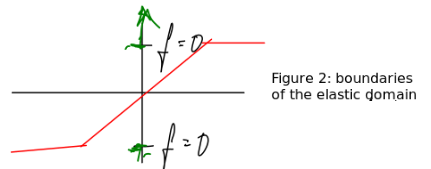

**Compass:** Let us postulate, that the amount of yielding can be mathematically controlled by a nonnegative variable $\lambda$. Yielding is assumed to proceed in a normal direction with respect to the yield surface $f$
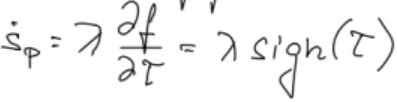
\begin{align}
\dot{s}^\mathrm{pl}
\label{eq:s_p_rage} = \lambda \frac{\partial f}{\partial \tau}
\end{align}

In [34]:
if False:
    s_0, s_f = sp.symbols(r's_0, s_f')
    omega_ =  (s_0 / s * sp.exp(-(s-s_0)/(s_f-s_0) ) )
    dot_omega_ = omega_.diff(s)
    omega_, dot_omega_

In [36]:
S, c, r = sp.symbols('S,c,r')
Y = sp.symbols('Y')
Y_ = E_b * s**2 / 2
phi_ext_ = S * (1-omega)**c / (r+1) * (Y/S)**(r+1)

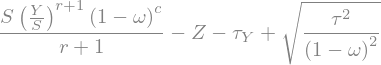

In [37]:
phi_ = f_tau_.subs(tau_eff, tau_eff_) + phi_ext_
phi_

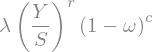

In [39]:
lambda_ = sp.symbols(r'\lambda', nonnegative=True)
dot_omega_ = sp.simplify(lambda_ * phi_.diff(Y))
dot_omega_

In [41]:
dot_z_ = -lambda_ * phi_.diff(Z)
dot_z_

But how far do we go along the direction given by the gradient $\partial f / \partial \tau$? The amount of yielding 
is now controlled by a new unknown variable $\lambda$? 

The idea that helps to sort this out and to mathematically distinguish the loading steps into elastic and inelastic ones is provided by the **Kuhn-Tucker condition**
\begin{align}
  \lambda f = 0, \; \lambda > 0,\; f \le 0
  \label{eq:kuhn_tucker}
\end{align}
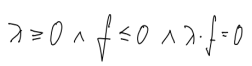
This construct acts as a switch between either growing $\lambda > 0$ (yielding) or negative $f < 0$ (elastic loading, or unloading) or both $\lambda = 0$ and $f=0$ (neutral loading). Still, it does not provide the additional condition to get $\lambda$ resolved in case of yielding ... 

### Consistency condition
If the material is yielding, then $f = 0$ and $\lambda \le 0$. Moreover, <font color="green">the value of $f$ must **remain zero** during the whole yielding process</font>. This means that the rate of the yield function, i.e. 
\begin{align}
\frac{ \mathrm{d} f}{\mathrm{d} t} = \dot{f} = 0
  \label{eq:consistency}
\end{align}
must remain zero as well. This is the sought condition that can be used to resolve for $\lambda$. 

To construct the rate of the yield condition let us recall that it depends on stress, which in turn depends on the control slip and on the plastic slip
\begin{align}
 f:= f( \tau (s, \omega), \omega )
 \nonumber
\end{align}
Thus, to obtain $\dot{f}$ we  can apply the chain rule 
\begin{align}
\dot{f} &= 
\frac{\mathrm{d} f}{\mathrm{d} t} =
\frac{\partial f}{\partial \tau} \frac{\mathrm{d} \tau}{\mathrm{d} t} 
+
\frac{\partial^{\mathrm{dir}} f}{\partial^{\mathrm{dir}} \omega} \frac{\mathrm{d} \omega}{\mathrm{d} t}
= \frac{\partial f}{\partial \tau} 
(1-\omega)E_\mathrm{b}\dot{s} - \dot{\omega}E_\mathrm{b}s +
\frac{\partial f}{\partial \omega} \dot{\omega}
= \frac{\partial f}{\partial \tau} E_\mathrm{b}\left( \dot{s} - \dot{s}^\mathrm{pl} \right)
  \label{eq:f_chain_derivatives}
\end{align}

To realize this derivation in `sympy` let us transform the elastic relation from absolute values into the rate form
\begin{align}
\dot{\tau} = (1 - \omega) E_\mathrm{b} \dot{s} - \dot{\omega} E_\mathrm{b} s
\label{eq:elastic_rate}
\end{align}

In [46]:
dot_s, dot_omega = sp.symbols(r'\dot{s}, \dot{\omega}')
dot_tau_ = (1 - omega) * E_b * dot_s - dot_omega * E_b * s
dot_tau_

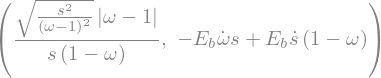

In [47]:
dot_f_tau_ = sp.simplify(f_tau_.diff(tau)).subs(tau,tau_)
dot_f_tau_, dot_tau_

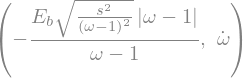

In [48]:
dot_f_omega_ = sp.simplify(f_tau_.diff(omega)).subs(tau,tau_)
dot_f_omega_, dot_omega

In [52]:
dot_f_Z_ = sp.simplify(f_tau_.diff(Z))
dot_f_Z_, dot_Z_

In [61]:
dot_f_ = (dot_f_tau_ * dot_tau_ + dot_f_omega_ * dot_omega + dot_f_Z_ * dot_Z_)
dot_f_simp = sp.simplify(dot_f_)
#dot_f_

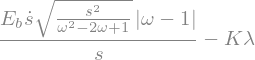

In [62]:
dot_f_simp.subs(dot_z, dot_z_)

By setting this expression to zero and resolving for $\lambda$ we obtain 

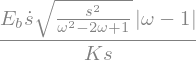

In [64]:
lambda_solved = sp.solve( dot_f_simp.subs(dot_z, dot_z_), lambda_)[0]
lambda_solved

In [70]:
dot_omega_solved = dot_omega_.subs(lambda_, lambda_solved)

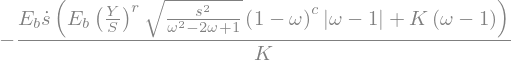

In [73]:
sp.simplify(dot_tau_.subs(dot_omega, dot_omega_solved))

## Numerical iterative solution
So far, we have expressed the change of the yield condition as a time derivative without considering the history that a material point went through. To move through an inelastic space of a material, let us now consider a discrete instance of time $t_n$ with the history represented by known values of $s_{n}$ and $s^{\mathrm{pl}}_{n}$ and $z_n$ for which the Kuhn-Tucker conditions $\eqref{eq:kuhn_tucker}$ are fulfilled.

Let us now prescribe an increment of total control slip $\Delta s$ to achieve the state at $t_{n+1}$ as
\begin{align}
s_{n+1} = s_n + \Delta s
\end{align}
Since the state variable $\omega_{n+1}$ is unknown, let us start by evaluating the yield function with the values known from the previous step
\begin{align}
f(s_{n+1}, \omega_n)
\end{align}
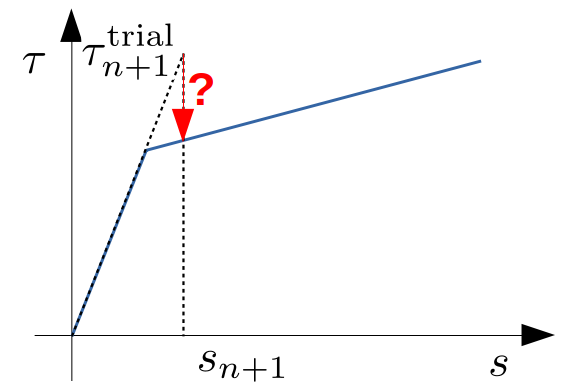

### Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
 \dot{f}(\tau(s, \omega(\lambda)) &= 0.
\end{align}
Thus, it was impossible to reach an inadmissible state beyond the yield locus. In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}, s^{\mathrm{pl}}_n, z_n)$ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. $f(s_{n+1}, s_n^\mathrm{pl}, z_n)$.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
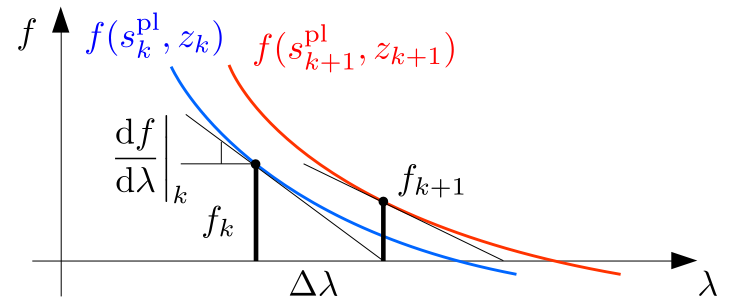
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variable $\omega_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

### State update
In every iteration step the state variables $\omega$ must be updated using the discrete evolution equations, i.e. 

\begin{align}
\omega_{k+1} &= \omega_n + \lambda_{k+1} \left. \frac{\partial \varphi}{\partial Y} \right|_k
\label{eq:discrete_evolution}
\end{align}

### Predictor operator
Recalling that $f(\tau(s,\omega(\lambda)))$ the chain rule delivers the expression

\begin{align}
\left. \frac{\partial f}{\partial \lambda} \right|_k
&= 
\left.\frac{\partial f}{\partial \omega} \right|_k
\left.\frac{\partial \omega}{\partial \lambda} \right|_k =
\left.\frac{\partial f}{\partial \omega} \right|_k
\left.\frac{\partial \varphi}{\partial Y} \right|_k
\end{align}

In [ ]:
df_dlambda_k = sp.simplify(f_tau_.diff(omega) * phi_.diff(Y).subs(Y,Y_))
get_df_dlambda_k = sp.lambdify((s, tau, omega, E_b, S, r, c) , df_dlambda_k, 'numpy')
df_dlambda_k

In [ ]:
dphi_dY_k = sp.simplify(phi_.diff(Y).subs(Y,Y_))
dphi_dY_k

### Time stepping algorithm
Substituting back into the recurrent formula we obtain the solution for $\Delta \lambda$

\begin{align}
 f_k + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda =
 f_k - (E_\mathrm{b} + K) \Delta \lambda = 0
 \implies
 \Delta \lambda = \frac{f_k}{E_\mathrm{b}+K}
\end{align}

Apparently, the derivative of $f$ with respect to $\lambda$ is linear in the present model. This means that the solution can be found in a single iteration step. This gives us the chance to derive an explicit analytical formulas for return mapping in a time step $s_{n+1} = s_n + \Delta s$ with state variables $s^\mathrm{pl}_n, z_n$ as follows:
<font color="blue">
\begin{align}
 \tau_{k} &= E_b(s_{n+1} - s^{\mathrm{pl}}_n) \nonumber \\
 Z_k &= K z_n \\
 f_k &= | \tau_k | - Z_k - \tau_{\mathrm{Y}} \nonumber \\
 \Delta \lambda &= \frac{f_k}{E_\mathrm{b} + K} \\
s^\mathrm{pl}_{n+1} &= \Delta \lambda \; \mathrm{sign}(\tau_k)
\nonumber \\
z_{n+1} &= \Delta \lambda \nonumber \\
n &= n+1 \nonumber
\end{align}</font>

In [ ]:
n_cycles, s_max, n_steps = 10, 3, 500 # load history parameters
_E_b, _K, _tau_Y = 10, 0.2, 1 # material parameters
_S, _r, _c = 0.1, 1, 1 # damage parameters
s_pl_k, z_k = 0, 0 # initialization of trial states
tau_list = [] # list to record the stresses
t_arr = np.linspace(0,1,n_steps) # time range t in (0,1)
theta = np.sin(2*n_cycles * np.pi * t_arr) # load history with unloading
s_n1_arr = s_max * theta # load history
for s_n1 in s_n1_arr:
    f_k, df_k, tau_k = get_f_df(s_n1, tau_k, omega_k, z_k, *margs)
    if f_k > 0: # inelastic step - return mapping
        delta_lambda_k = f_k / df_k
        omega_k += delta_lambda_k * np.sign(tau_k)
        z_k += delta_lambda_k # to save lines n=n+1 is shortend to k
        f_k, df_k, tau_k = get_f_df(s_n1, tau_k, omega_k, z_k, *margs)
        f_k, df_k, tau_k = get_f_df(s_n1, tau_k, omega_k, z_k, *margs)
    tau_list.append(tau_k) # record the calculated stress
_, (ax_t, ax_tau) = plt.subplots(1,2,figsize=(10,4))
ax_t.plot(t_arr, s_n1_arr,color='black'); ax_t.set_ylabel('$s$'), ax_t.set_xlabel('$t$')
ax_tau.plot(s_n1_arr, tau_list, color='green'); ax_tau.set_ylabel(r'$\tau$'), ax_tau.set_xlabel('$s$');
ax_t.set_title('loading history'); ax_tau.set_title('stress-slip'); 

### Tasks and questions
 1. Extend the model with kinematic hardening $X = \gamma \alpha$ following the lecture video V0403.
 2. Use the model extended model to find and extend answers to questions in exercise X0401.
 3. What behavior is obtained for one loading cycle with $K = 0.1, \gamma = -0.1$ and for $K = -0.1, \gamma = 0.1$ - for monotonic and for cyclic loading?
 4. Use the model to find an explanation why do the interchanged signs for kinematic and isotropic hardening lead to a completely different cyclic response.